In [1]:
#mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#importing libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Problem **1a**

In [8]:
#data loading
data = pd.read_csv('/content/drive/MyDrive/Class/Intro-to-ML-main/Datasets/Housing.csv')

In [9]:
X = data.drop(columns=['price']) #features (all columns except 'price' column
y = data['price'] #output variable

In [10]:
#non-numeric column
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
multi_category_columns = ['furnishingstatus']

#applying label encoding for binrary categorical columns
le = LabelEncoder()
for col in binary_columns:
    X[col] = le.fit_transform(X[col])

#apply One-Hot Encoding for multi-category columns
X = pd.get_dummies(X, columns=multi_category_columns, drop_first=True)


In [80]:
#split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize features to scale them between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  #fit and transform the training data
X_val = scaler.transform(X_val)  #transform the validation data

#normalize target values to scale them between 0 and 1
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = target_scaler.transform(y_val.values.reshape(-1, 1))

In [81]:
#convert to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [82]:
#create dataloader for batching the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [83]:
#defining the nn model with one hidden layer
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)  #first fully connected layer (input to hidden)
        self.relu = nn.ReLU()  #activation function (ReLU)
        self.fc2 = nn.Linear(8, 1)  #output layer (hidden to output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [84]:
#initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  #number of features after encoding
model = SimpleNN(input_dim)
criterion = nn.MSELoss()  #MSE as loss function for regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)   #Adam optimizer with learning rate 0.0001


In [85]:
#training the model
epochs = 1000
patience = 20 # number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

#lists to store loss values for plotting
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch_X, batch_y in train_loader:  # Loop through mini-batches
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(batch_X)  # Forward pass through the network
        loss = criterion(outputs, batch_y)  # Calculate the loss
        loss.backward()  # Backpropagate to compute gradients
        optimizer.step()  # Update weights based on gradients

    # Evaluation on validation data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)  # Forward pass for validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Calculate validation loss

    # Store losses for plotting
    training_losses.append(loss.item())
    validation_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print loss for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

print(f'Final Validation Loss: {val_loss.item():.4f}')

Epoch [100/1000], Loss: 0.0267, Validation Loss: 0.0235
Epoch [200/1000], Loss: 0.0085, Validation Loss: 0.0178
Epoch [300/1000], Loss: 0.0027, Validation Loss: 0.0168
Epoch [400/1000], Loss: 0.0179, Validation Loss: 0.0165
Early stopping at epoch 489
Final Validation Loss: 0.0164


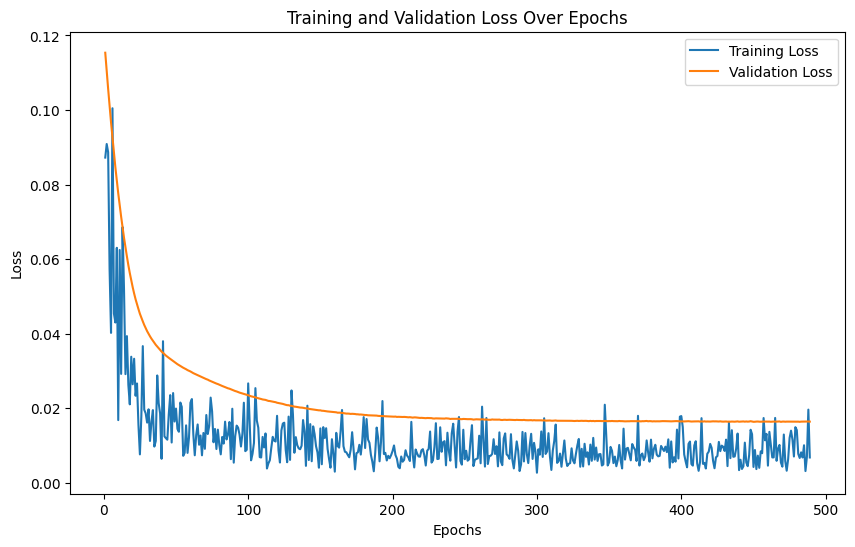

In [86]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()


# Problem **1b**

In [76]:
#define the extended model with three hidden layers
class ExtendedNN(nn.Module):
    def __init__(self, input_dim):
        super(ExtendedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)  #first hidden layer
        self.relu1 = nn.ReLU()  #activation function for first hidden layer
        self.fc2 = nn.Linear(8, 16)  #second hidden layer
        self.relu2 = nn.ReLU()  #activation function for second hidden layer
        self.fc3 = nn.Linear(16, 8)  #third hidden layer
        self.relu3 = nn.ReLU()  #activation function for third hidden layer
        self.fc4 = nn.Linear(8, 1)  #output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x


In [87]:
#initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  #number of features after encoding
model = ExtendedNN(input_dim)
criterion = nn.MSELoss()  #MSE as loss function for regression
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)   #Adam optimizer with learning rate 0.0001 and L2 regularization

In [88]:
#training the model
epochs = 1000
patience = 20 # number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

#lists to store loss values for plotting
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()  #set the model to training mode
    for batch_X, batch_y in train_loader:  #loop through mini-batches
        optimizer.zero_grad()  #zero the gradients from the previous step
        outputs = model(batch_X)  #forward pass through the network
        loss = criterion(outputs, batch_y)  #calculate the loss
        loss.backward()  #backpropagate to compute gradients
        optimizer.step()  #update weights based on gradients

    #evaluation on validation data
    model.eval()  #set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)  #forward pass for validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # calculate validation loss

    # store losses for plotting
    training_losses.append(loss.item())
    validation_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print loss for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

print(f'Final Validation Loss: {val_loss.item():.4f}')

Epoch [100/1000], Loss: 0.0174, Validation Loss: 0.0219
Epoch [200/1000], Loss: 0.0076, Validation Loss: 0.0176
Early stopping at epoch 273
Final Validation Loss: 0.0175


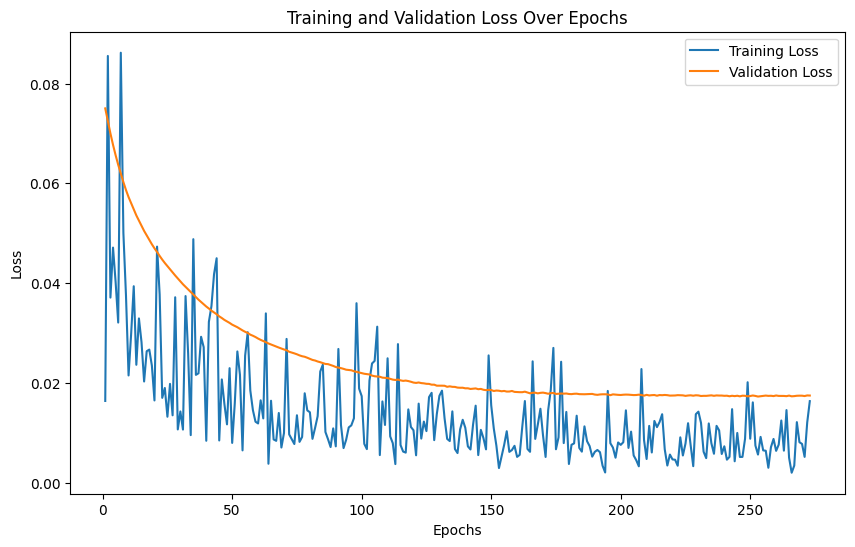

In [90]:
#plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()


# Problem **2a**

In [19]:
#import dataset
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import time

In [92]:
#loading dataset
data = load_breast_cancer()
X = data.data #features
y = data.target#labels (0 for malignant, 1 for benign)

In [94]:
#split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize features to ensure they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  #fit and transform the training data
X_val = scaler.transform(X_val)  #transform the validation data

In [95]:
#convert to pytorch tensors for compatibility with PyTorch's models
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  #reshape for binary classification
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

#create dataloader for batching the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [96]:
#defining model with one hidden layer containing 32 nodes
class CancerNN(nn.Module):
    def __init__(self, input_dim):
        super(CancerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  #first fully connected layer (input to hidden)
        self.relu = nn.ReLU()  #activation function (ReLU)
        self.fc2 = nn.Linear(32, 1)  #Output layer (hidden to output)
        self.sigmoid = nn.Sigmoid()  #sigmoid activation for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [97]:
#initiate model, loss function, and optimizer
input_dim = X_train.shape[1]  #number of features
model = CancerNN(input_dim)
criterion = nn.BCELoss()  #binary Cross-Entropy as loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  #learning rate

In [98]:
#training the model with early stopping
epochs = 1000
patience = 20  # number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# lists to store loss values for plotting
training_losses = []
validation_losses = []

start_time = time.time()  # track training time

for epoch in range(epochs):
    model.train()  # set the model to training mode
    for batch_X, batch_y in train_loader:  # loop through mini-batches
        optimizer.zero_grad()  # zero the gradients from the previous step
        outputs = model(batch_X)  # forward pass through the network
        loss = criterion(outputs, batch_y)  # calculate the loss
        loss.backward()  # backpropagate to compute gradients
        optimizer.step()  # update weights based on gradients

    # evaluation on validation data
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)  # forward pass for validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # calculate validation loss

    # store losses for plotting
    training_losses.append(loss.item())
    validation_losses.append(val_loss.item())

    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # print loss for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')
print(f'Final Validation Loss: {val_loss.item():.4f}')

# evaluate accuracy on validation set
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor)
    val_preds = (val_preds >= 0.5).float()  # convert probabilities to binary predictions
    accuracy = accuracy_score(y_val_tensor, val_preds)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Epoch [100/1000], Loss: 0.1720, Validation Loss: 0.1061
Epoch [200/1000], Loss: 0.0647, Validation Loss: 0.0634
Epoch [300/1000], Loss: 0.0139, Validation Loss: 0.0550
Epoch [400/1000], Loss: 0.0298, Validation Loss: 0.0536
Early stopping at epoch 413
Training Time: 13.11 seconds
Final Validation Loss: 0.0539
Validation Accuracy: 99.12%


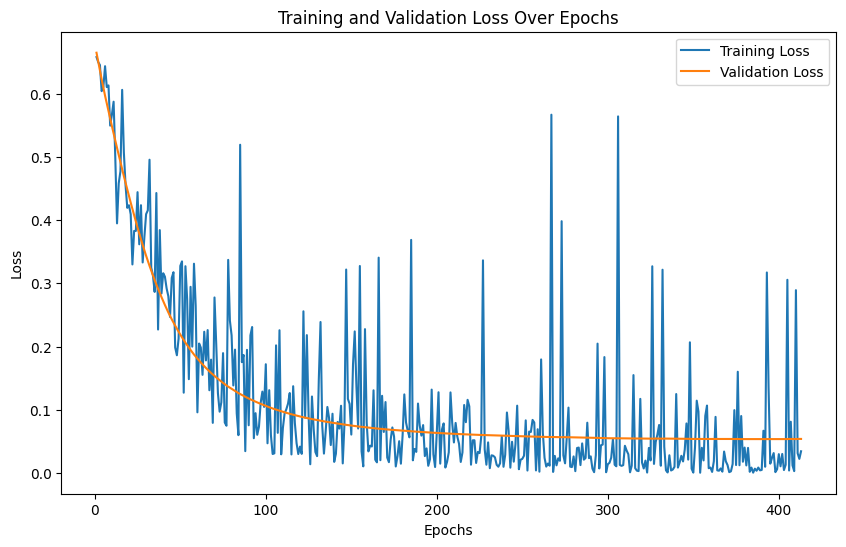

In [99]:
#plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# **Problem 2b**

In [100]:
#defining the extended model with three hidden layers
class ExtendedCancerNN(nn.Module):
    def __init__(self, input_dim):
        super(ExtendedCancerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # first hidden layer
        self.relu1 = nn.ReLU()  # activation function for first hidden layer
        self.fc2 = nn.Linear(32, 64)  #second hidden layer
        self.relu2 = nn.ReLU()  #activation function for second hidden layer
        self.fc3 = nn.Linear(64, 32)  #third hidden layer
        self.relu3 = nn.ReLU()  #activation function for third hidden layer
        self.fc4 = nn.Linear(32, 1)  #output layer
        self.sigmoid = nn.Sigmoid()  #sigmoid activation for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [102]:
#initiate model, loss function, and optimizer
input_dim = X_train.shape[1]  #number of features
model = CancerNN(input_dim)
criterion = nn.BCELoss()  #binary Cross-Entropy as loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  #learning rate with L2 regularizaiton

In [103]:
#training the model with early stopping
epochs = 1000
patience = 20  # number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# lists to store loss values for plotting
training_losses = []
validation_losses = []

start_time = time.time()  # track training time

for epoch in range(epochs):
    model.train()  # set the model to training mode
    for batch_X, batch_y in train_loader:  # loop through mini-batches
        optimizer.zero_grad()  # zero the gradients from the previous step
        outputs = model(batch_X)  # forward pass through the network
        loss = criterion(outputs, batch_y)  # calculate the loss
        loss.backward()  # backpropagate to compute gradients
        optimizer.step()  # update weights based on gradients

    # evaluation on validation data
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)  # forward pass for validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # calculate validation loss

    # store losses for plotting
    training_losses.append(loss.item())
    validation_losses.append(val_loss.item())

    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # print loss for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')
print(f'Final Validation Loss: {val_loss.item():.4f}')

# evaluate accuracy on validation set
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor)
    val_preds = (val_preds >= 0.5).float()  # convert probabilities to binary predictions
    accuracy = accuracy_score(y_val_tensor, val_preds)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Epoch [100/1000], Loss: 0.1009, Validation Loss: 0.1211
Epoch [200/1000], Loss: 0.0591, Validation Loss: 0.0669
Epoch [300/1000], Loss: 0.0031, Validation Loss: 0.0565
Early stopping at epoch 377
Training Time: 7.70 seconds
Final Validation Loss: 0.0547
Validation Accuracy: 98.25%


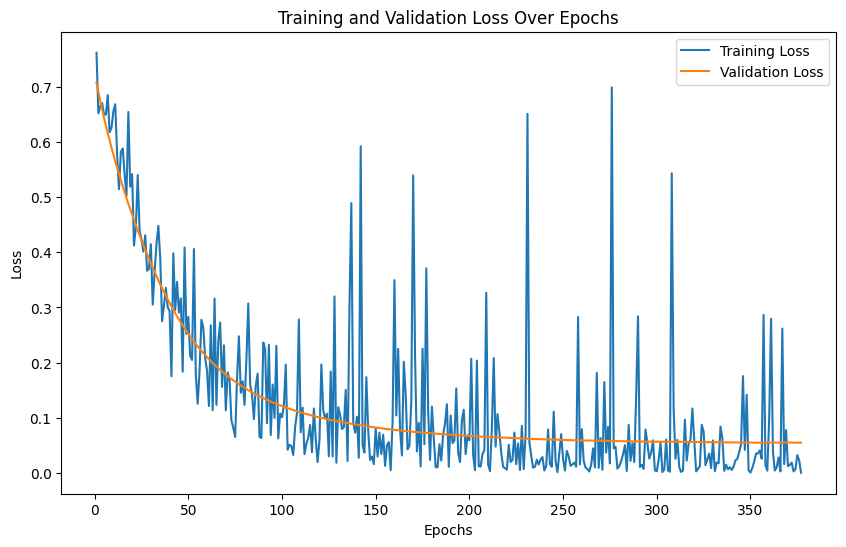

In [104]:
#plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# **Problem 3a**

In [18]:
#importing libraries
import torchvision
import torchvision.transforms as transforms

In [20]:
#check GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [36]:
#loading CIFAR-10 dataset &transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #normalize to range [-1, 1]
])
#download and load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
#download and load the CIFAR-10 validation dataset.
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
#defining the model with one hidden layer of size 256 neurons
class CIFAR10NN(nn.Module):
    def __init__(self, input_dim):
        super(CIFAR10NN, self).__init__()
        #define the first fully connected layer (input to hidden layer)
        self.fc1 = nn.Linear(input_dim, 256)  #hidden layer with 256 nodes
        self.batch_norm = nn.BatchNorm1d(256)  #batch normalization
        self.dropout = nn.Dropout(0.3) # dropout with probability of 0.5
        self.relu = nn.ReLU()  #activation function
        self.fc2 = nn.Linear(256, 10)  #output layer (10 classes for CIFAR-10)

    def forward(self, x):
        #flatten the input tensor (batch_size, channels, height, width) -> (batch_size, input_dim)
        x = x.view(x.size(0), -1)  # Flatten the input
        #apply the first layer followed by ReLU activation
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        #apply the output layer
        x = self.fc2(x)
        return x

In [46]:
#initialize the model, loss function, and optimizer
input_dim = 3 * 32 * 32  #CIFAR-10 images are 3x32x32 (3 channels, 32x32 pixels)
model = CIFAR10NN(input_dim).to(device) #move model to device if available
criterion = nn.CrossEntropyLoss()  #cross-entropy for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  #adam optimizer with learning rate

In [47]:
#training the model
epochs = 100
training_losses = []  #list to store training loss for each epoch
validation_losses = []  #list to store validation loss for each epoch
training_accuracies = []  #list to store training accuracy for each epoch
validation_accuracies = []  #list to store validation accuracy for each epoch

start_time = time.time()  #track training time

for epoch in range(epochs):
    model.train()  #set model to training mode
    running_loss = 0.0  #track total loss for the epoch
    correct_train = 0  #track number of correct predictions during training
    total_train = 0  # track total number of training samples

    #loop over each batch in the training dataset
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  #move data to GPU if available
        optimizer.zero_grad()  #zero the gradients from the previous iteration
        outputs = model(batch_X)  #forward pass through the model
        loss = criterion(outputs, batch_y)  #calculate loss between predicted and true labels
        loss.backward()  #backward pass to compute gradients
        optimizer.step()  #update weights using computed gradients

        running_loss += loss.item()  #accumulate loss for the current batch
        _, predicted = torch.max(outputs.data, 1)  #get predicted classes
        total_train += batch_y.size(0)  #update total number of samples
        correct_train += (predicted == batch_y).sum().item()  #update number of correct predictions

    #calculate average training loss for the epoch
    training_loss = running_loss / len(train_loader)
    #calculate training accuracy for the epoch
    training_accuracy = 100 * correct_train / total_train
    #store training loss and accuracy
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #validation step
    model.eval()  #set model to evaluation mode
    val_loss = 0.0  #track total validation loss
    correct_val = 0  #track number of correct predictions during validation
    total_val = 0  #track total number of validation samples

    #loop over each batch in the validation dataset
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) # move data to gpu
            outputs = model(batch_X)  #forward pass through the model
            loss = criterion(outputs, batch_y)  #calculate validation loss
            val_loss += loss.item()  #accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)  #get predicted classes
            total_val += batch_y.size(0)  #update total number of samples
            correct_val += (predicted == batch_y).sum().item()  #update number of correct predictions

    #calculate average validation loss for the epoch
    validation_loss = val_loss / len(val_loader)
    #calculate validation accuracy for the epoch
    validation_accuracy = 100 * correct_val / total_val
    #store validation loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    #print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

#calculate total training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')
print(f'Final Training Loss: {training_losses[-1]:.4f}, Final Training Accuracy: {training_accuracies[-1]:.2f}%')
print(f'Final Validation Loss: {validation_losses[-1]:.4f}, Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')


Epoch [10/100], Training Loss: 1.2921, Training Accuracy: 55.18%, Validation Loss: 1.3214, Validation Accuracy: 53.61%
Epoch [20/100], Training Loss: 1.1575, Training Accuracy: 59.90%, Validation Loss: 1.3156, Validation Accuracy: 54.36%
Epoch [30/100], Training Loss: 1.0703, Training Accuracy: 62.77%, Validation Loss: 1.3251, Validation Accuracy: 54.40%
Epoch [40/100], Training Loss: 1.0028, Training Accuracy: 65.30%, Validation Loss: 1.3237, Validation Accuracy: 55.24%
Epoch [50/100], Training Loss: 0.9482, Training Accuracy: 66.88%, Validation Loss: 1.3303, Validation Accuracy: 55.33%
Epoch [60/100], Training Loss: 0.8965, Training Accuracy: 68.94%, Validation Loss: 1.3434, Validation Accuracy: 54.84%
Epoch [70/100], Training Loss: 0.8599, Training Accuracy: 70.34%, Validation Loss: 1.3768, Validation Accuracy: 54.73%
Epoch [80/100], Training Loss: 0.8318, Training Accuracy: 70.98%, Validation Loss: 1.3807, Validation Accuracy: 55.17%
Epoch [90/100], Training Loss: 0.8103, Training 

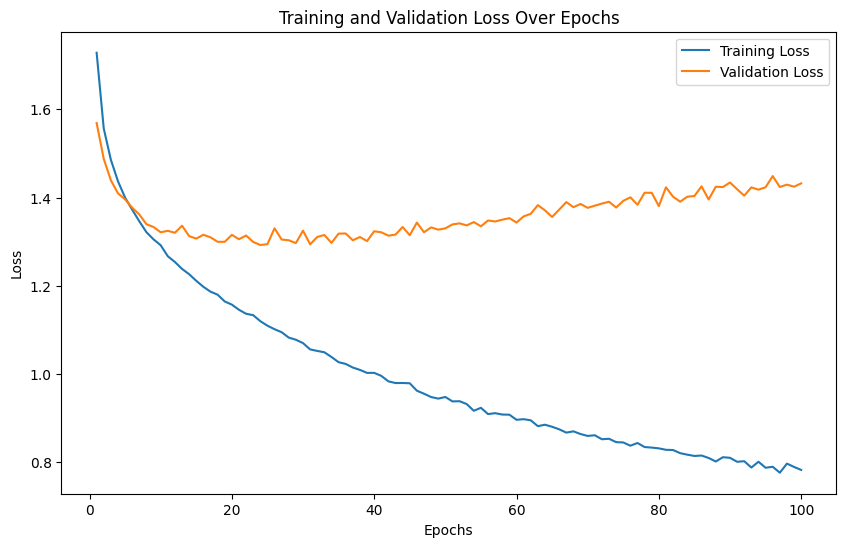

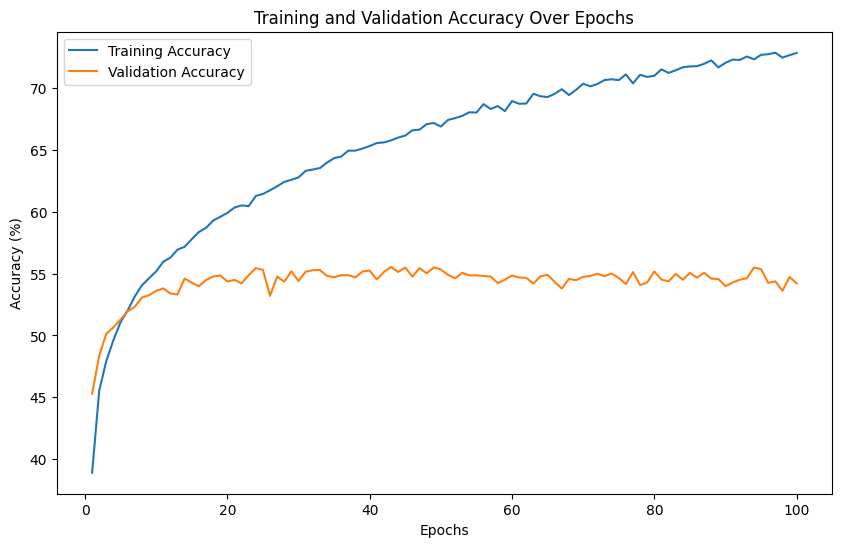

In [48]:
#plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

# **Problem 3b**

In [49]:
#defining the model with one hidden layer of size 256 neurons
class CIFAR10NN(nn.Module):
    def __init__(self, input_dim):
        super(CIFAR10NN, self).__init__()
        #define the first fully connected layer (input to hidden layer)
        self.fc1 = nn.Linear(input_dim, 256)  #hidden layer with 256 nodes
        self.batch_norm1 = nn.BatchNorm1d(256)  #batch normalization
        self.fc2 = nn.Linear(256, 256)  #second hidden layer with 256 nodes
        self.batch_norm2 = nn.BatchNorm1d(256)  #batch normalization
        self.fc3 = nn.Linear(256, 256)  #third hidden layer with 256 nodes
        self.batch_norm3 = nn.BatchNorm1d(256)  #batch normalization
        self.dropout = nn.Dropout(0.3) # dropout with probability of 0.5
        self.relu = nn.ReLU()  #activation function
        self.fc4 = nn.Linear(256, 10)  #output layer (10 classes for CIFAR-10)

    def forward(self, x):
        #flatten the input tensor (batch_size, channels, height, width) -> (batch_size, input_dim)
        x = x.view(x.size(0), -1)  # Flatten the input
        #apply the first layer followed by ReLU activation
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        #apply the output layer
        x = self.fc4(x)
        return x

In [50]:
#initialize the model, loss function, and optimizer
input_dim = 3 * 32 * 32  #CIFAR-10 images are 3x32x32 (3 channels, 32x32 pixels)
model = CIFAR10NN(input_dim).to(device) #move model to device if available
criterion = nn.CrossEntropyLoss()  #cross-entropy for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  #adam optimizer with learning rate

In [51]:
#training the model
epochs = 100
training_losses = []  #list to store training loss for each epoch
validation_losses = []  #list to store validation loss for each epoch
training_accuracies = []  #list to store training accuracy for each epoch
validation_accuracies = []  #list to store validation accuracy for each epoch

start_time = time.time()  #track training time

for epoch in range(epochs):
    model.train()  #set model to training mode
    running_loss = 0.0  #track total loss for the epoch
    correct_train = 0  #track number of correct predictions during training
    total_train = 0  # track total number of training samples

    #loop over each batch in the training dataset
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  #move data to GPU if available
        optimizer.zero_grad()  #zero the gradients from the previous iteration
        outputs = model(batch_X)  #forward pass through the model
        loss = criterion(outputs, batch_y)  #calculate loss between predicted and true labels
        loss.backward()  #backward pass to compute gradients
        optimizer.step()  #update weights using computed gradients

        running_loss += loss.item()  #accumulate loss for the current batch
        _, predicted = torch.max(outputs.data, 1)  #get predicted classes
        total_train += batch_y.size(0)  #update total number of samples
        correct_train += (predicted == batch_y).sum().item()  #update number of correct predictions

    #calculate average training loss for the epoch
    training_loss = running_loss / len(train_loader)
    #calculate training accuracy for the epoch
    training_accuracy = 100 * correct_train / total_train
    #store training loss and accuracy
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #validation step
    model.eval()  #set model to evaluation mode
    val_loss = 0.0  #track total validation loss
    correct_val = 0  #track number of correct predictions during validation
    total_val = 0  #track total number of validation samples

    #loop over each batch in the validation dataset
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) # move data to gpu
            outputs = model(batch_X)  #forward pass through the model
            loss = criterion(outputs, batch_y)  #calculate validation loss
            val_loss += loss.item()  #accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)  #get predicted classes
            total_val += batch_y.size(0)  #update total number of samples
            correct_val += (predicted == batch_y).sum().item()  #update number of correct predictions

    #calculate average validation loss for the epoch
    validation_loss = val_loss / len(val_loader)
    #calculate validation accuracy for the epoch
    validation_accuracy = 100 * correct_val / total_val
    #store validation loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    #print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

#calculate total training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.2f} seconds')
print(f'Final Training Loss: {training_losses[-1]:.4f}, Final Training Accuracy: {training_accuracies[-1]:.2f}%')
print(f'Final Validation Loss: {validation_losses[-1]:.4f}, Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')

Epoch [10/100], Training Loss: 1.2686, Training Accuracy: 54.66%, Validation Loss: 1.2678, Validation Accuracy: 54.67%
Epoch [20/100], Training Loss: 1.1283, Training Accuracy: 59.81%, Validation Loss: 1.2261, Validation Accuracy: 56.70%
Epoch [30/100], Training Loss: 1.0288, Training Accuracy: 63.27%, Validation Loss: 1.2304, Validation Accuracy: 57.16%
Epoch [40/100], Training Loss: 0.9739, Training Accuracy: 65.40%, Validation Loss: 1.2221, Validation Accuracy: 57.33%
Epoch [50/100], Training Loss: 0.9258, Training Accuracy: 67.07%, Validation Loss: 1.2454, Validation Accuracy: 56.25%
Epoch [60/100], Training Loss: 0.8877, Training Accuracy: 68.40%, Validation Loss: 1.2405, Validation Accuracy: 57.45%
Epoch [70/100], Training Loss: 0.8496, Training Accuracy: 69.70%, Validation Loss: 1.2706, Validation Accuracy: 57.08%
Epoch [80/100], Training Loss: 0.8434, Training Accuracy: 70.24%, Validation Loss: 1.2780, Validation Accuracy: 57.23%
Epoch [90/100], Training Loss: 0.8206, Training 

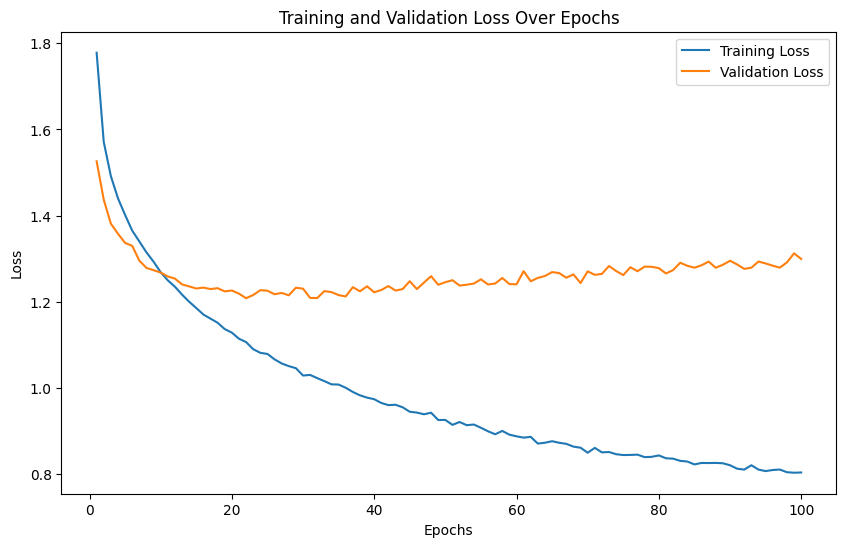

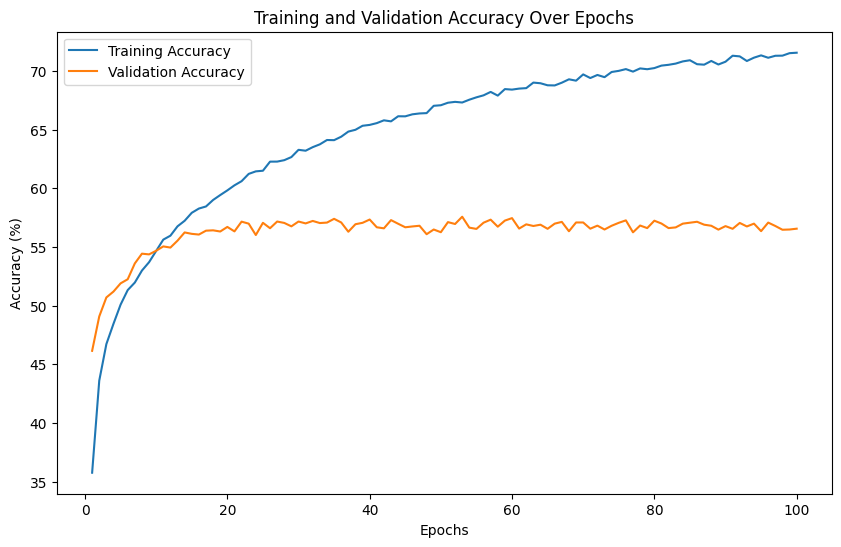

In [52]:
#plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()